In [1]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np 

import os           # To obtain the path of the Python document #
                         

from utils import make_gif            # To generate gifs from images #

from utils import unity_partition_2d  # Funtion that introduces a 
                                      #      partition of the unity in [-1,1]x[-1,1]#

from utils import batches_gen         # To generate batches fror the Mini-batch #

from solvers import solver_op         # Solver of the obstacle problem 
                                      #      (motivate by ) #

from solvers import solver_avg_mb_op  # Solver of the mini-batch obstacle problem.
                                      #       It compute the mean of different realization 
                                      #       of the mini-batch gradient flow asociated to
                                      #       the obstacle problem. See [https://arxiv.org/abs/2407.07556]#


####  For fancy plots  ####

from matplotlib.ticker import MaxNLocator 
from matplotlib import cm
from matplotlib.transforms import Bbox    
from matplotlib.patches import Rectangle  

In [2]:
#### Create a folder to save images  ####

cwd = os.getcwd() # We obtain the location of the current file

# We create a new path to save the images
newpath = os.path.join(cwd,"images/example_paper_images_test") 
if not os.path.exists(newpath):  
    os.makedirs(newpath)

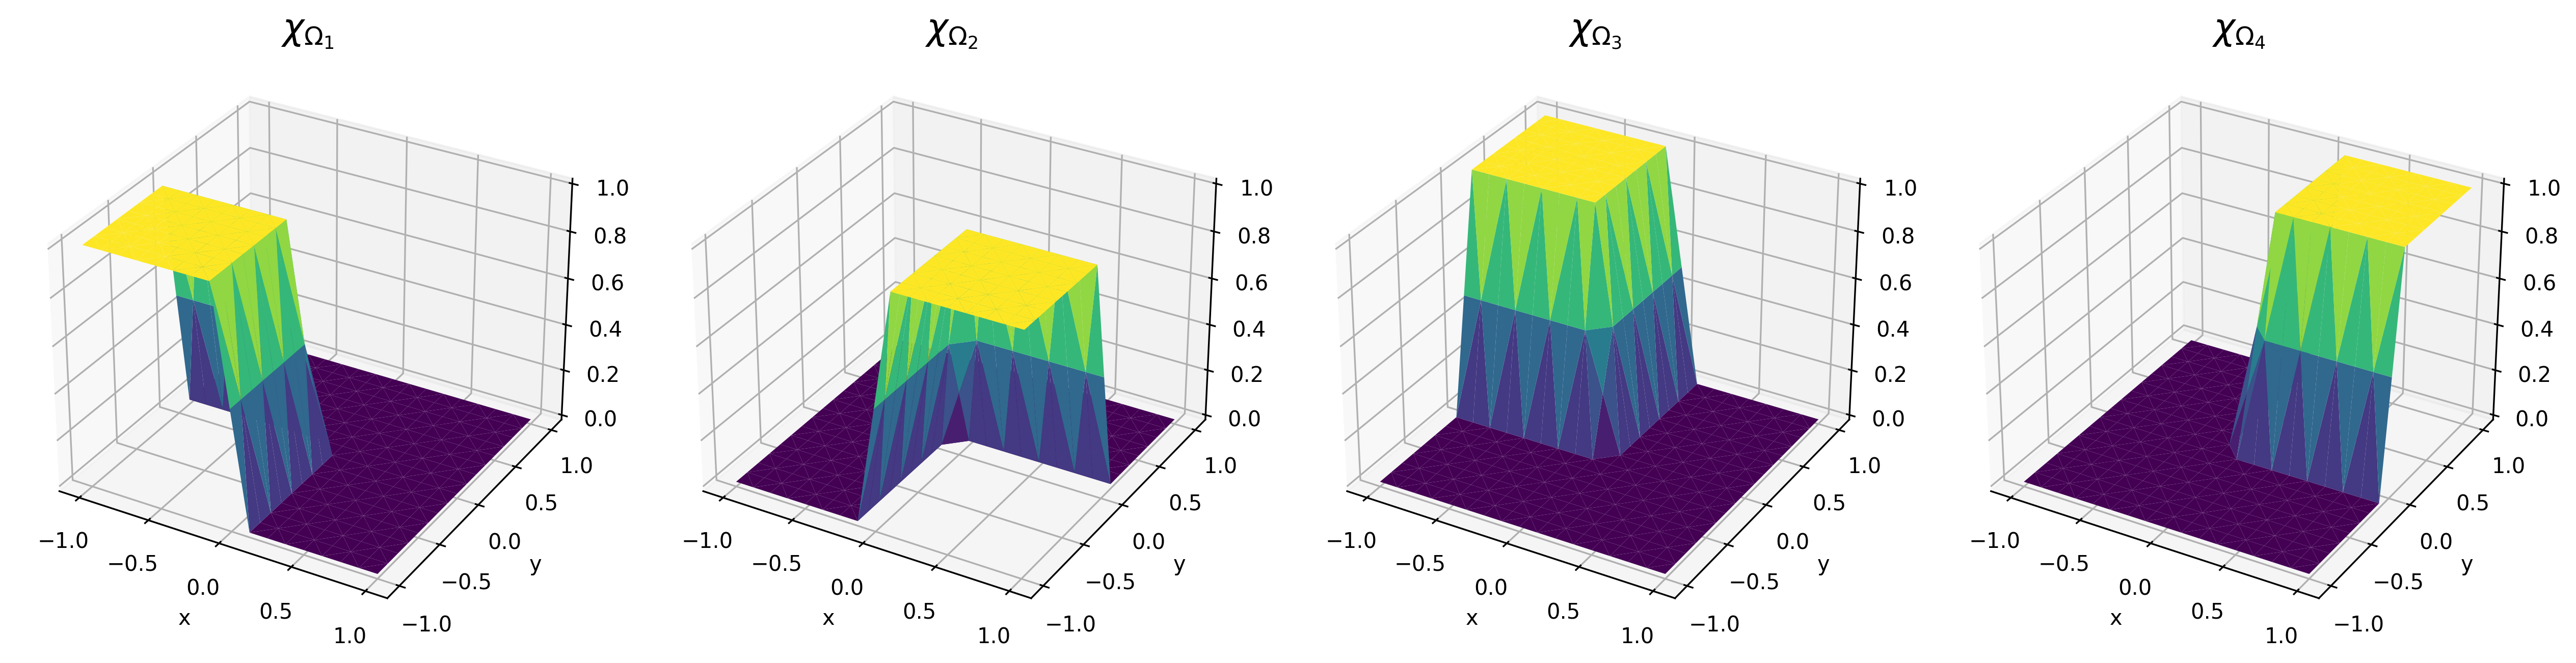

In [3]:
#### Let us plot the partitition of the 2d-unity ####

# Define a mesh on the rectangle [-1,1]x[-1,1] with 16*16 elements
mesh = RectangleMesh(Point(-1, -1), Point(1, 1), 16, 16)   
# Define the standar basis functions in the mesh 
V = FunctionSpace(mesh, 'CG', 1)

# Interpolate the UserExpression into the function space
n_values = [0, 1, 2, 3]
functions = [interpolate(unity_partition_2d(n=n, degree=1), V) for n in n_values]

# Extract coordinates and function values
coordinates = mesh.coordinates()
x, y = coordinates[:, 0], coordinates[:, 1]

# Plot the results using plot_trisurf
fig = plt.figure(figsize=(17, 10), dpi=300)
axs = [fig.add_subplot(1, 4, i+1, projection='3d') for i in range(4)]

for ax, f, n in zip(axs, functions, n_values):
    z = np.array([f(Point(coord[0], coord[1])) for coord in coordinates])
    ax.plot_trisurf(x, y, z, cmap='viridis',linewidth=1)
    ax.set_title(r'$ \chi_{\Omega_'+str(n+1)+'}$',size=17)    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.xaxis.set_major_locator(MaxNLocator(nbins=5))
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    
# Save the solution in the folder already created
plt.savefig(newpath+'/figure_chi_functions.pdf', dpi=300, bbox_inches='tight')    
plt.tight_layout()
plt.show()

In [4]:
#### Let us solve the obstacle problem with our solver ####

example = 'example_2' # Example_1: 1d example.  Example_2: 2d example
nx=20                 # Number of elements in the mesh. Here nx^d elements are considered (d is the dimension of the problem)
nt=60                 # Number of time discretizations
T=0.5                 # Time horizont


print("Running the solver for the OP..")
un_list, obstacle,X,Y = solver_op(example,nx, T, nt)
print("Finish")


Running the solver for the OP..
Finish


In [5]:
#### Let us solve the mini-batch obstacle problem and compute average with our solver ####

n_seed=5      # Fix a seed for the batches
itera=4       # Number of realizations

bat = batches_gen(nt, itera,n_seed,example) # Generate the batches for the mini-batch

print("Running the solver for the MM..")
wn_list, _ = solver_avg_mb_op(bat,nx,nt,T,example,itera)
print("Finish")



Running the solver for the MM..
Realization number: 0
Realization number: 1
Realization number: 2
Realization number: 3
Finish


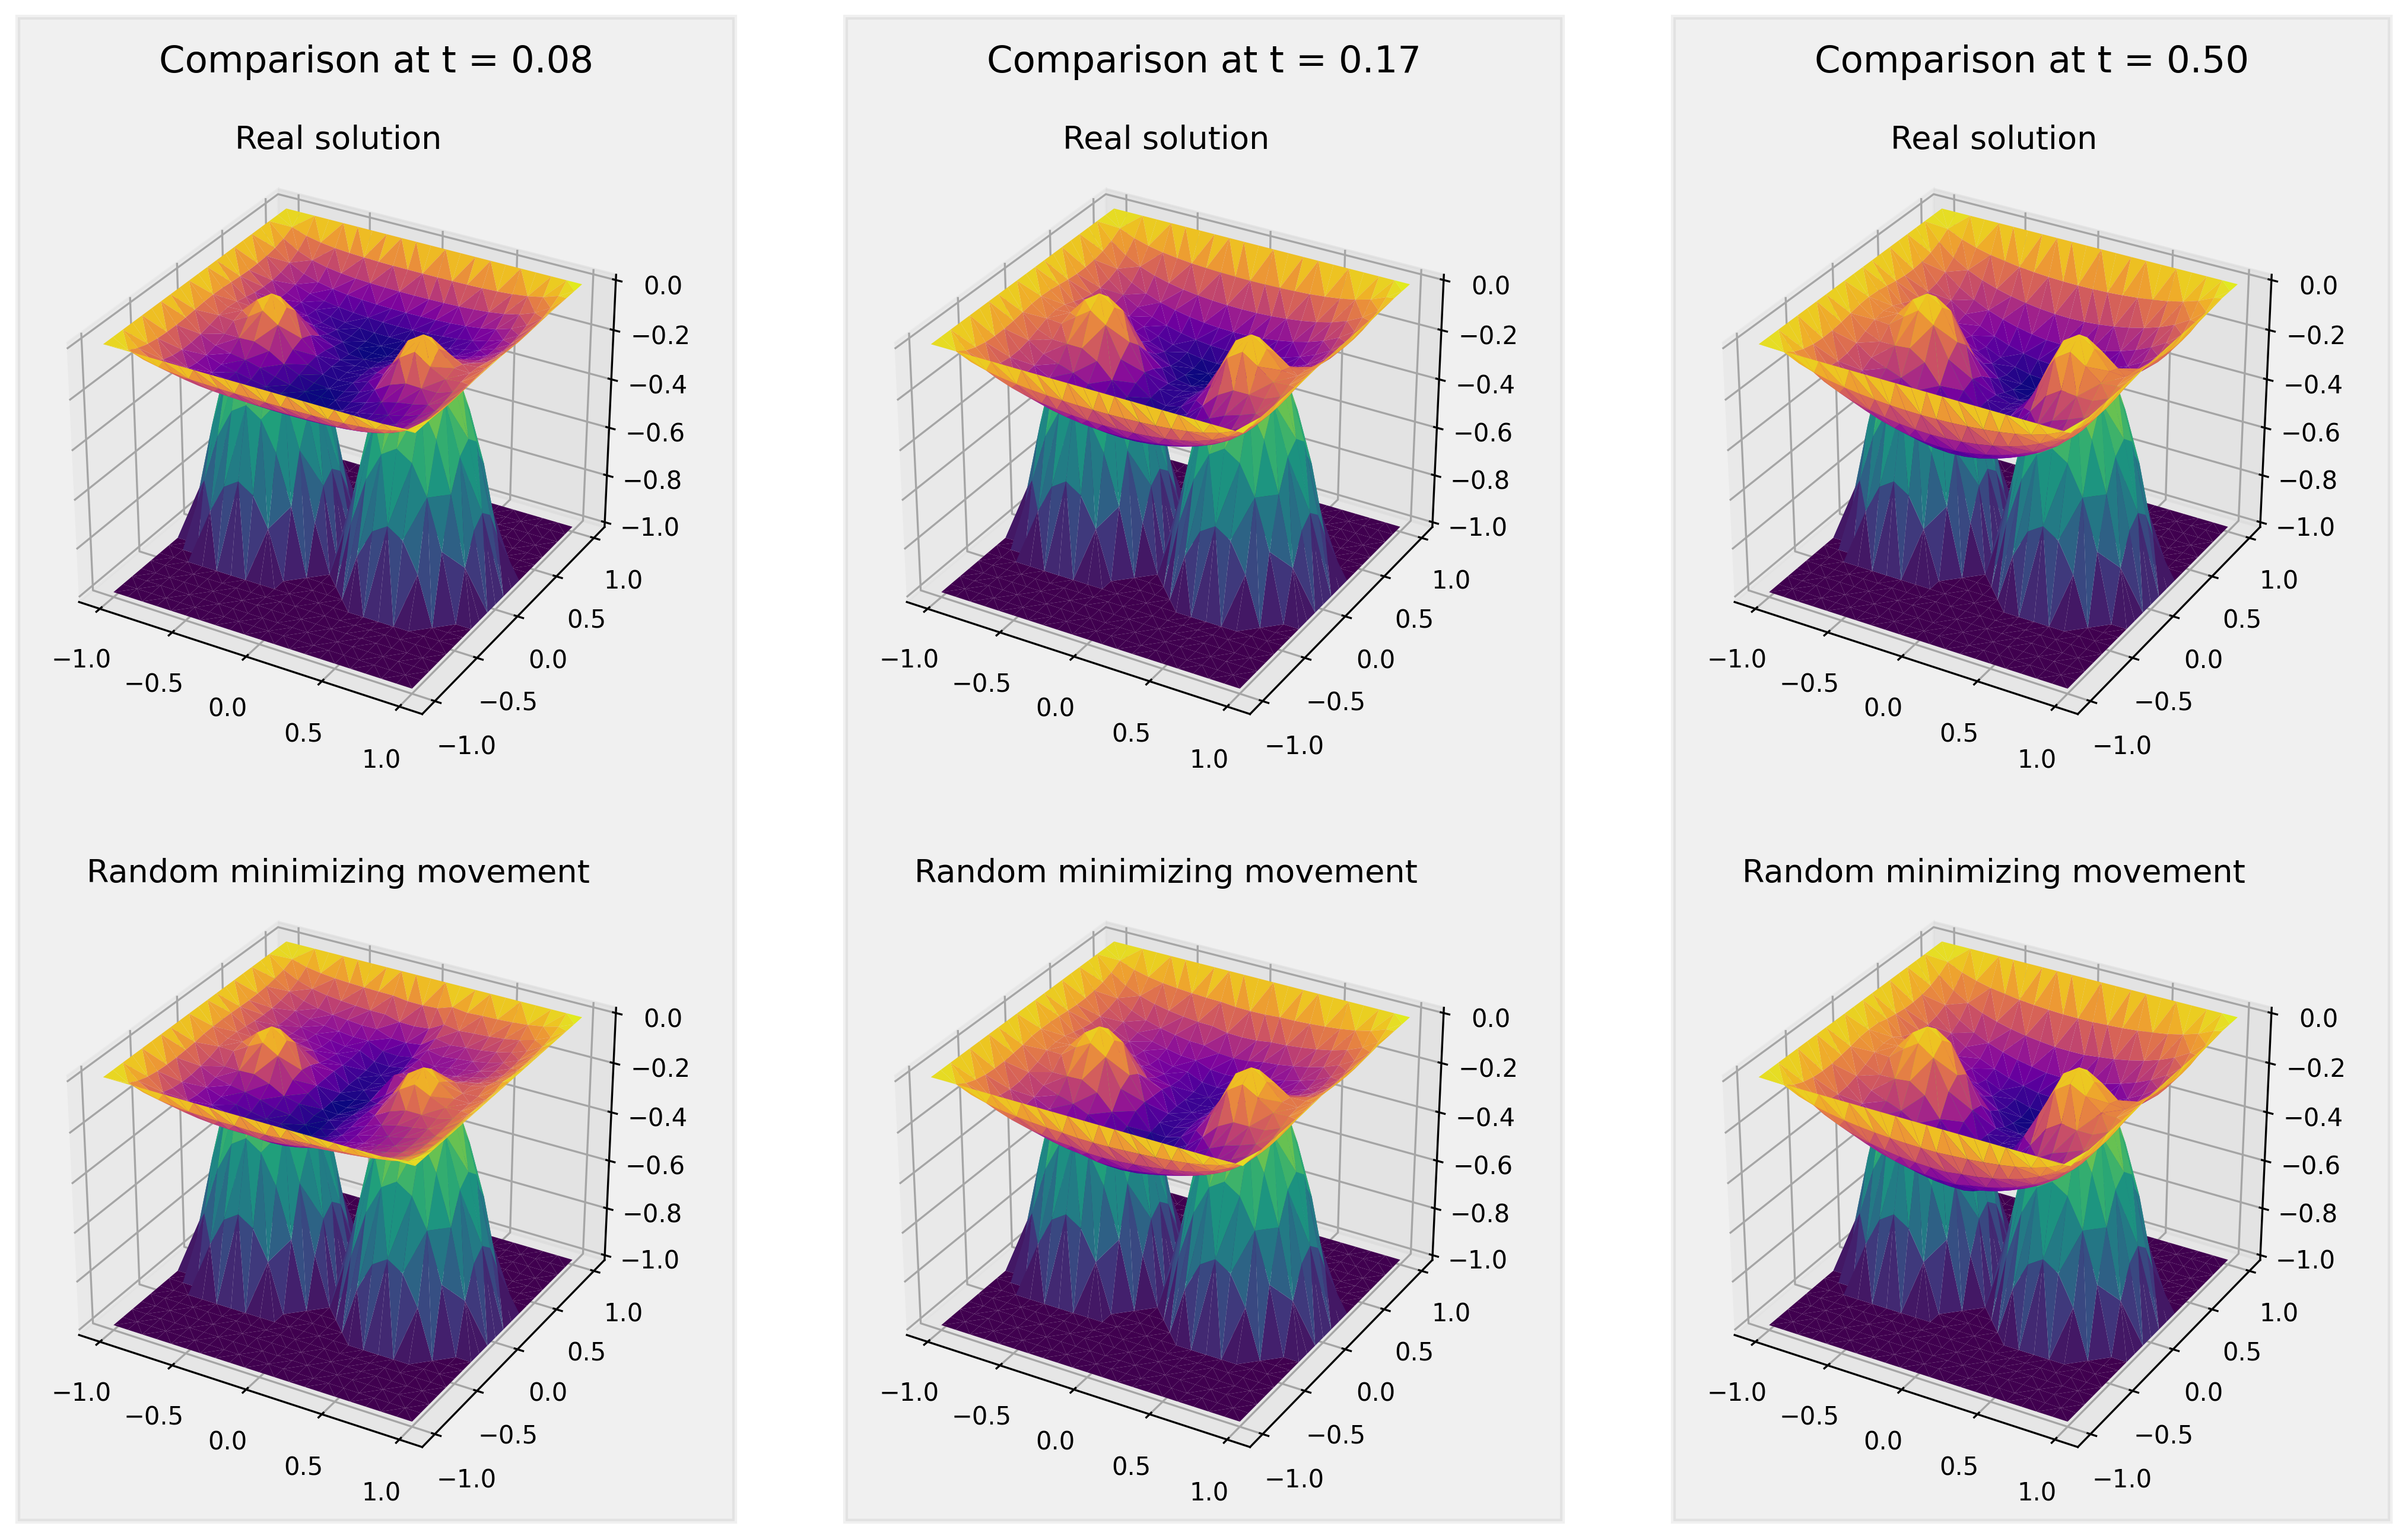

In [6]:
#### Let us plot our results for different times ####


times = np.linspace(0,T,nt+1)

# Plot the results using plot_trisurf
fig = plt.figure(figsize=(17, 10), dpi=300)
axs = [fig.add_subplot(2, 3, i+1, projection='3d') for i in range(6)]
n_values = [10,20,-1]  # Position in np.linspace(0,T,nt+1) of the times to be plot

for i, n in enumerate(n_values):
    # Plot un_list in the top row
    ax = axs[i]
    ax.plot_trisurf(X, Y, un_list[n], cmap=cm.plasma, linewidth=1)
    ax.plot_trisurf(X, Y, obstacle, cmap=cm.viridis, linewidth=1)
    ax.set_title(f'Real solution', size=13, y=1.15, pad=-17)

    # Plot wn_list in the bottom row
    ax = axs[i + 3]
    ax.plot_trisurf(X, Y, wn_list[n], cmap=cm.plasma, linewidth=1)
    ax.plot_trisurf(X, Y, obstacle, cmap=cm.viridis, linewidth=1)
    ax.set_title(f'Random minimizing movement', size=13, y=1.15, pad=-17)

# Add frames to enclose specific subplots
fig.canvas.draw()

# Define a small margin to increase the width and height of each rectangle
margin_u = 0.07
margin_r = 0.03
margin_l = 0.005
margin_d = 0.02
margin = 0.03 

# Frame 1: Encloses the first column of plots (P_11 and P_21)
bbox1_1 = axs[0].get_position()
bbox1_2 = axs[3].get_position()
bbox1 = Bbox.from_extents(min(bbox1_1.x0, bbox1_2.x0) - margin_l, min(bbox1_1.y0, bbox1_2.y0) - margin_d,
                          max(bbox1_1.x1, bbox1_2.x1) + margin_r, max(bbox1_1.y1, bbox1_2.y1) + margin_u)
rect1 = Rectangle((bbox1.x0, bbox1.y0), bbox1.width, bbox1.height, 
                  transform=fig.transFigure, color="black", linewidth=2, fill=True, alpha=0.06)
fig.patches.append(rect1)
fig.text(bbox1.x0 + bbox1.width / 2, bbox1.y1 - margin/2, f'Comparison at t = {times[n_values[0]]:.2f}', 
         horizontalalignment='center', verticalalignment='top', fontsize=15, color='black')

# Frame 2: Encloses the second column of plots (P_12 and P_22)
bbox2_1 = axs[1].get_position()
bbox2_2 = axs[4].get_position()
bbox2 = Bbox.from_extents(min(bbox2_1.x0, bbox2_2.x0) - margin_l, min(bbox2_1.y0, bbox2_2.y0) - margin_d,
                          max(bbox2_1.x1, bbox2_2.x1) + margin_r, max(bbox2_1.y1, bbox2_2.y1) + margin_u)
rect2 = Rectangle((bbox2.x0, bbox2.y0), bbox2.width, bbox2.height, 
                  transform=fig.transFigure, color="black", linewidth=2, fill=True, alpha=0.06)
fig.patches.append(rect2)
fig.text(bbox2.x0 + bbox2.width / 2, bbox2.y1 - margin/2, f'Comparison at t = {times[n_values[1]]:.2f}', 
         horizontalalignment='center', verticalalignment='top', fontsize=15, color='black')

# Frame 3: Encloses the third column of plots (P_13 and P_23)
bbox3_1 = axs[2].get_position()
bbox3_2 = axs[5].get_position()
bbox3 = Bbox.from_extents(min(bbox3_1.x0, bbox3_2.x0) - margin_l, min(bbox3_1.y0, bbox3_2.y0) - margin_d,
                          max(bbox3_1.x1, bbox3_2.x1) + margin_r, max(bbox3_1.y1, bbox3_2.y1) + margin_u)
rect3 = Rectangle((bbox3.x0, bbox3.y0), bbox3.width, bbox3.height, 
                  transform=fig.transFigure, color="black", linewidth=2, fill=True, alpha=0.06)
fig.patches.append(rect3)
fig.text(bbox3.x0 + bbox3.width / 2, bbox3.y1 - margin/2, f'Comparison at t = {times[n_values[2]]:.2f}', 
         horizontalalignment='center', verticalalignment='top', fontsize=15, color='black')

fig.savefig(newpath+'/deterministic_vs_random.pdf',dpi=300, bbox_inches='tight')    
plt.show()

In [7]:
#### Create a folder to save images for the gifs #### 

cwd = os.getcwd()
newpath = os.path.join(cwd,"images/for_gifs") 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [10]:
#### Save images for each time step to see the evolution ####


names_figure=[]
for i in range(nt):
    fig = plt.figure(dpi=100,figsize=(20,20))
    
    #### Figure 1 (obstacle problem)####
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_trisurf(X, Y, un_list[i],cmap=cm.plasma, linewidth=1)
    ax.plot_trisurf(X, Y, obstacle,cmap=cm.viridis, linewidth=1)
    ax.view_init(40, 65+i)  # Rotation of the image
    ax.set_title('Deterministic solution',size=20)

    #### Figure 2 (mini-batch) ####
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_trisurf(X, Y, wn_list[i],cmap=cm.plasma, linewidth=1)
    ax.plot_trisurf(X, Y, obstacle,cmap=cm.viridis, linewidth=1)
    ax.view_init(40, 65+i) # Rotation of the image
    ax.set_title('Random minimizing movement',size=20)

    #### Save the images
    name = newpath+'/plt_3d_'+str(i)+'.png'
    names_figure.append(name)
    save_path = os.path.join(newpath,'plt_3d_'+str(i)+'.png') # We save the names of the images          
    plt.savefig(save_path,dpi=100, bbox_inches='tight', pad_inches=0) # We save the images
    plt.close()

In [11]:
#### Generate the gif with the previous images ####

make_gif(names_figure,"comparation_solutions") 